<!-- @format -->

# Papuga, ppb oceny pozytywnej


In [8]:
import random

DATA = []
with open("reviews.txt", "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        line.strip()
        if i % 10 == 0:
            if line.startswith("GOOD"):
                DATA.append((line[4:].strip(), i, 1))  # trzeci parametr to etykieta
            else:
                DATA.append((line[3:].strip(), i, 0))

random.shuffle(DATA)
TEST_SET_SIZE = int(len(DATA) * 0.2)
TEST_SET = DATA[:TEST_SET_SIZE]
REVIEWS = [(r, idx) for r, idx, _ in DATA[TEST_SET_SIZE:]]
# print(REVIEWS)
# REVIEWS = [" Warto przejechać ponad 600 km żeby przez tydzień wypocząć w tym hotelu : )", "Obsługa hotelu bardzo przyjaźnie nastawiona, miła, uprzejma i pomocna, zawsze z uśmiechem.",
#           "Niestety już pierwszego dnia w recepcji czekała na nas bardzo niemiła niespodzianka.", " Po otwarciu drzwi pokoju uderzał nieprzyjemny zapach pleśni i wilgoci."]

PAPUGA_PROBS = []
EMBEDDINGS = []
for i in TEST_SET[0]:
    print(i)

Natomiast obiady fantastyczne, pyszne i porcje zadowalające mężczyzn.
160
1


<!-- @format -->

# Ocena PPB papugą


In [9]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from torch.nn import functional as F
from math import exp


model_name = "flax-community/papuGaPT2"
device = "cuda"
device = "cpu"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)


def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label


def sentence_prob(sentence_txt):
    input_ids = tokenizer(sentence_txt, return_tensors="pt")["input_ids"].to(device)
    with torch.no_grad():
        output = model(input_ids=input_ids)
        log_probs = log_probs_from_logits(output.logits[:, :-1, :], input_ids[:, 1:])
        seq_log_probs = torch.sum(log_probs)
    return seq_log_probs.cpu().numpy()


def determine_positive_probability(review: str) -> float:
    # deterimine bias
    prob_pos = sentence_prob(review + "- pozytywna")
    prob_neg = sentence_prob(review + "- negatywna")

    ppos, pneg = exp(prob_pos), exp(prob_neg)
    # probablility that it's positive
    prob = ppos / (ppos + pneg)
    # print("Papuga ppb pozytywnej opinii:", prob)
    return prob

<!-- @format -->

## Ocena PPB pozytywności recenzji, używając papugi

- <0.5 oznacza ocenę nagatywną


In [10]:
for rev, i in REVIEWS:
    prob = determine_positive_probability(rev)
    PAPUGA_PROBS.append((prob, i))

In [11]:
for rev, prob in zip(REVIEWS[:4], PAPUGA_PROBS[:4]):
    print(f"Review: {rev[0][:50]}\nPositive prob: {prob[0]}")

Review: Mają także kilka rowerów do wypożyczenia także nie
Positive prob: 0.8131769840277838
Review: ZaleceniaKupując wczasy z biura Rainbow dobrze się
Positive prob: 0.6444314204436477
Review: Szatnie na dole kolo basenu co może być kłopotliwe
Positive prob: 0.5569568997956822
Review: Pokoje te są zlokalizowane na piętrze pensjonatu, 
Positive prob: 0.9287947501169956


<!-- @format -->

# Embeddingi dla recenzji

- posłużną nam do analizy sentymentu


In [12]:
from transformers import AutoTokenizer, AutoModel


model_name = "allegro/herbert-base-cased"
device = "cpu"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)


def calculate_sentence_embeding(sentence: str):
    token_ids = tokenizer(sentence, return_tensors="pt")["input_ids"][0]

    # tokens = [self.tokenizer.decode(idx) for idx in token_ids]
    outputs = model(token_ids.unsqueeze(0))

    sentence_embedding = outputs.last_hidden_state[0][0]

    # for token, embedding in zip(tokens, embeddings):
    #     print(f"\nToken: '{token}'")
    #     print(f"Embedding: {embedding}")

    return sentence_embedding

Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<!-- @format -->

## Obliczamy embedingi dla kolejnych recenzji


In [13]:
for rev, i in REVIEWS:
    emb = calculate_sentence_embeding(rev)
    EMBEDDINGS.append((emb, i))

<!-- @format -->

#### Wykres embedingów zrzutowanych na 2d i kolory na podstawie tego czy są pozytywne czy negatywne


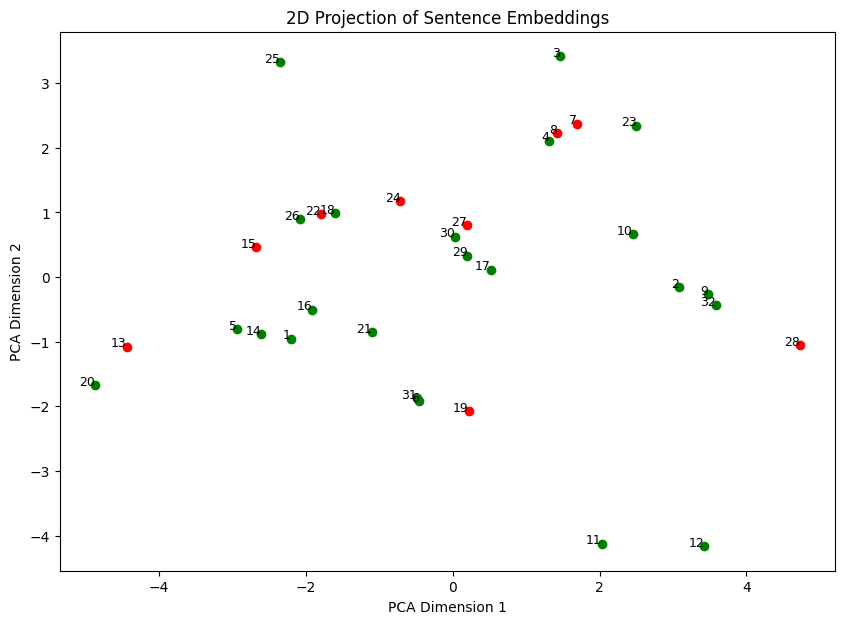

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch

# lista tensorów staje się jednym tensorem
embeds = [emb for emb, i in EMBEDDINGS]
embedding_matrix = torch.stack(embeds).detach().numpy()

# pca
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embedding_matrix)

# przyporządkowanie kolorów
probs = [prob for prob, i in PAPUGA_PROBS]
colors = ["red" if prob < 0.5 else "green" for prob in probs]

plt.figure(figsize=(10, 7))
for idx, (x, y) in enumerate(reduced_embeddings):
    plt.scatter(x, y, color=colors[idx], label=f"Review {idx+1}" if idx < 4 else "")
    plt.text(x, y, f"{idx+1}", fontsize=9, ha="right")

plt.title("2D Projection of Sentence Embeddings")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.show()

<!-- @format -->

# Regresja logistyczna

- cechy to embedingi, a labale nadaliśmy papugą
- potem zbadamy accuracy na zbiorze testowym, na prawdziwych labelach


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np

# bierzemy dane z zanużeń i labele od papugi
X_train = np.array([emb.detach().numpy() for emb, _ in EMBEDDINGS])
y_train = np.array([1 if prob > 0.5 else 0 for prob, _ in PAPUGA_PROBS])

X_test = np.array([rev for rev, _, _ in TEST_SET])
y_test = np.array([label for _, _, label in TEST_SET])

print(X_train[0], y_train[0], X_test[0], y_test[0])
# trenujemy model
model = LogisticRegression(max_iter=1000, solver="lbfgs")
model.fit(X_train, y_train)

# dla wytrenowanego robimy predykcję
y_pred = model.predict(X_test)

# ewaluacja wyniku
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

[-3.51600975e-01  4.97571602e-02 -4.43674922e-02  1.74020693e-01
  8.72576237e-02  2.93659091e-01 -4.57003638e-02 -3.35796744e-01
 -2.25000724e-01 -2.66698562e-02  3.20891261e-01  1.17581375e-01
  1.15212512e+00 -4.15023744e-01  3.67025286e-02  5.21711297e-02
  2.82149374e-01 -1.30000755e-01  1.37282461e-01  9.38784853e-02
  5.30457497e-01 -4.07125205e-02  7.34402835e-02 -4.12798613e-01
 -1.16104577e-02 -8.64212736e-02  3.01914573e-01  1.29738033e-01
 -2.17211723e-01  1.28094852e-03 -1.33871317e-01  3.19305450e-01
  9.94411111e-03 -5.03238380e-01  2.98661888e-01  5.06515145e-01
 -2.38774806e-01  4.92997169e-02  4.02504712e-01 -3.52857888e-01
  6.16001785e-02  4.63414639e-02 -2.42486507e-01  6.86430112e-02
  1.27374932e-01  7.00377822e-02 -4.31741476e-02  1.13825038e-01
 -5.84573075e-02 -3.20572518e-02 -6.06937408e-02 -1.55006379e-01
  1.22727647e-01  5.82003966e-02  2.93664515e-01 -3.49673480e-02
  1.96570784e-01  2.70140022e-02 -8.34229141e-02  9.06631112e-01
  1.00507736e-01  2.44668

ValueError: Expected 2D array, got 1D array instead:
array=['Natomiast obiady fantastyczne, pyszne i porcje zadowalające mężczyzn.'
 'Jedzenie w porządku.'
 'Polecamy wycieczki z przewodniczką Bożenką jest wspaniale.'
 'Pokój z widokiem na północ 0 gór.' 'Pokoje przestronne i wygodne.'
 'Ale jak juz sa komplikacje to chyba nie jest najlepszy.'
 'Niestety, nie wyleczył mnie do końca - brakło mu pomysłów.'
 'Bajkoterapia działa!'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.